In [43]:
# Dependencies
import pandas as pd
import numpy as np
# Plotting
import matplotlib.pyplot as plt
# Stationarity
from statsmodels.tsa.stattools import adfuller
# VAR model
from statsmodels.tsa.api import VAR
# # Pincipal Component Analysis
# from sklearn.decomposition import PCA


In [44]:
# Load data (FRED-MD)
df = pd.read_csv(
    'current.csv',
)
transformation_codes = df.iloc[0]
df = df.iloc[1:]  # Remove the first row (codes)
# Parse data
df.index = pd.to_datetime(df.iloc[:, 0])
data = df.iloc[:, 1:]  # Remove the first column (dates)

# Make the series stationary
def transform_series(series, code):
    if code == 1:
        return series  # No transformation
    elif code == 2:
        return series.diff().dropna()  # First difference
    elif code == 3:
        return series.diff().diff().dropna()  # Second difference
    elif code == 4:
        return np.log(series).dropna()  # Logarithm
    elif code == 5:
        return np.log(series).diff().dropna()  # First difference of logarithm
    elif code == 6:
        return np.log(series).diff().diff().dropna()  # Second difference of logarithm
    elif code == 7:
        return series.pct_change().dropna()  # Percentage change
    else:
        raise ValueError(f"Unknown transformation code: {code}")

transformed_data = {}

for column in data.columns:
    code = transformation_codes[column]
    transformed_data[column] = transform_series(data[column], code)

# Set index
data = pd.DataFrame(transformed_data).dropna()
display(data)


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1992-03-01,0.001467,0.000590,0.001830,0.004017,-0.003001,0.008381,0.008338,0.008783,0.008871,0.020222,...,0.001291,-0.000182,0.000836,0.011670,-0.003556,7.2,-0.016313,0.001663,-0.003791,16.2227
1992-04-01,0.003587,0.002574,0.000833,0.006642,0.006017,0.007652,0.007433,0.007499,0.009322,0.018415,...,-0.002156,0.000792,0.000830,-0.005836,0.001759,1.2,0.037147,-0.005843,0.001367,16.1885
1992-05-01,0.005188,0.005346,0.005164,-0.008738,0.005467,0.003283,0.005520,0.005877,0.006537,0.030857,...,0.000964,-0.002580,-0.002514,-0.000726,-0.000890,2.0,-0.052941,0.000207,0.004045,14.7280
1992-06-01,0.004069,0.004316,0.002703,0.010487,0.002804,0.000564,-0.002470,-0.003155,-0.004910,-0.013889,...,0.003219,0.000265,0.002500,0.007957,-0.000883,1.2,0.045621,0.008812,-0.000894,14.7531
1992-07-01,-0.000888,-0.001450,0.003318,0.013303,0.007080,0.009022,0.010146,0.011477,0.013214,0.026242,...,-0.002373,0.002632,-0.004169,-0.015187,-0.000003,-3.8,-0.003523,-0.008544,0.002273,13.3036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-01,0.000551,0.000025,0.001363,0.004770,-0.002785,0.002654,0.004202,0.003526,0.005423,-0.001019,...,-0.001163,0.000954,0.000956,0.001403,0.001427,-0.9,-0.004221,-0.003046,0.009716,12.6826
2024-07-01,0.001320,0.000871,0.004333,0.007163,0.012031,-0.007136,-0.007462,-0.008259,-0.010192,-0.058491,...,0.003849,0.000041,0.000303,0.000271,0.001048,-1.8,0.003282,0.004003,-0.004194,14.4084
2024-08-01,0.000950,0.000968,0.000711,0.000375,-0.001144,0.004810,0.004447,0.006822,0.008385,0.046971,...,-0.002222,-0.000061,-0.002576,-0.000291,-0.005741,1.5,-0.001974,-0.000766,0.001445,19.6750


In [45]:
# Check for stationarity
for idx, col in enumerate(data.columns):
    col_data = data[col].dropna()
    result = adfuller(col_data)
    if result[1] > 0.05:
        # Apply differencing and check again
        print(f"Applying to difference to {col}")
        col_data = col_data.diff().dropna()
        result = adfuller(col_data)
        if result[1] > 0.05:
            print(f'{idx}: {col} is still not stationary after differencing')
    data[col] = col_data
data = data.dropna()
display(data)

Applying to difference to CES0600000007
Applying to difference to AWHMAN
Applying to difference to HOUST
Applying to difference to HOUSTNE
Applying to difference to HOUSTMW
Applying to difference to HOUSTS
Applying to difference to HOUSTW
Applying to difference to PERMIT
Applying to difference to PERMITNE
Applying to difference to PERMITMW
Applying to difference to PERMITS
Applying to difference to PERMITW
Applying to difference to T10YFFM
Applying to difference to BAAFFM


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1992-04-01,0.003587,0.002574,0.000833,0.006642,0.006017,0.007652,0.007433,0.007499,0.009322,0.018415,...,-0.002156,0.000792,0.000830,-0.005836,0.001759,1.2,0.037147,-0.005843,0.001367,16.1885
1992-05-01,0.005188,0.005346,0.005164,-0.008738,0.005467,0.003283,0.005520,0.005877,0.006537,0.030857,...,0.000964,-0.002580,-0.002514,-0.000726,-0.000890,2.0,-0.052941,0.000207,0.004045,14.7280
1992-06-01,0.004069,0.004316,0.002703,0.010487,0.002804,0.000564,-0.002470,-0.003155,-0.004910,-0.013889,...,0.003219,0.000265,0.002500,0.007957,-0.000883,1.2,0.045621,0.008812,-0.000894,14.7531
1992-07-01,-0.000888,-0.001450,0.003318,0.013303,0.007080,0.009022,0.010146,0.011477,0.013214,0.026242,...,-0.002373,0.002632,-0.004169,-0.015187,-0.000003,-3.8,-0.003523,-0.008544,0.002273,13.3036
1992-08-01,0.003797,0.003723,0.002486,-0.016036,0.003241,-0.005579,-0.001268,-0.001363,0.000087,-0.008911,...,-0.000299,-0.002848,0.004991,0.011575,0.000870,-0.5,-0.006336,0.011634,0.000346,14.4223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-01,0.000551,0.000025,0.001363,0.004770,-0.002785,0.002654,0.004202,0.003526,0.005423,-0.001019,...,-0.001163,0.000954,0.000956,0.001403,0.001427,-0.9,-0.004221,-0.003046,0.009716,12.6826
2024-07-01,0.001320,0.000871,0.004333,0.007163,0.012031,-0.007136,-0.007462,-0.008259,-0.010192,-0.058491,...,0.003849,0.000041,0.000303,0.000271,0.001048,-1.8,0.003282,0.004003,-0.004194,14.4084
2024-08-01,0.000950,0.000968,0.000711,0.000375,-0.001144,0.004810,0.004447,0.006822,0.008385,0.046971,...,-0.002222,-0.000061,-0.002576,-0.000291,-0.005741,1.5,-0.001974,-0.000766,0.001445,19.6750


In [46]:
# Check for any na
for idx, col in enumerate(data.columns):
    if data[col].isna().any():
        print(f'{idx}: {col} has NaN values')


In [50]:
# Find 10 columns most correlated with CPIAUCSL
corr = data.corr()
cpi_corr = corr['CPIAUCSL'].sort_values(ascending=False)
print(cpi_corr)
# Select top 10 correlated columns
top_corr = cpi_corr.index[0:2]
final_data = data[top_corr]
# Display the selected columns
display(final_data)

CPIAUCSL         1.000000
CUSR0000SA0L5    0.988637
CPIULFSL         0.979962
CUSR0000SA0L2    0.975523
CUSR0000SAC      0.948501
                   ...   
M2REAL          -0.233970
EXCAUSx         -0.235501
BOGMBASE        -0.242449
TWEXAFEGSMTHx   -0.244414
ISRATIOx        -0.298914
Name: CPIAUCSL, Length: 126, dtype: float64


,CPIAUCSL,CUSR0000SA0L5
sasdate,,
1992-04-01,-0.001447,-0.000740
1992-05-01,-0.000005,-0.000005
1992-06-01,0.000709,0.000724
1992-07-01,-0.000008,-0.000735
1992-08-01,-0.000718,0.000720
...,...,...
2024-06-01,-0.000620,-0.000382
2024-07-01,0.002110,0.002657
2024-08-01,0.000322,0.000238


In [51]:
# Split the data into training and test sets
PERIODS = 6
# Split data into train (excluding last 6 periods)
train_data = final_data[:-PERIODS]

# The actual last 6 periods for comparison
test_data = final_data[-PERIODS:]

In [52]:
# Initialize and fit the VAR model
var_model = VAR(train_data)
selected_lags = var_model.select_order()
best_lag = selected_lags.aic  # Choose based on AIC (or bic)

# Fit the model with the best lag order
var_results = var_model.fit(best_lag)

/home/js/macroeconvue/modeling/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [53]:
# Get the last observed values for forecasting
last_obs = train_data.values[-best_lag:]

# Forecast the next 6 periods
forecast = var_results.forecast(last_obs, steps=PERIODS)

# Convert forecast to DataFrame
forecast_df = pd.DataFrame(
    forecast, 
    columns=final_data.columns,  # Preserve column names
    index=test_data.index  # Maintain time index
)
# Display the forecast
display(forecast_df)



,CPIAUCSL,CUSR0000SA0L5
sasdate,,
2024-05-01,-0.000136,0.000030
2024-06-01,0.000801,0.000763
2024-07-01,-0.000181,-0.000117
2024-08-01,-0.001121,-0.001293
2024-09-01,-0.000049,-0.000054
2024-10-01,0.000570,0.000625


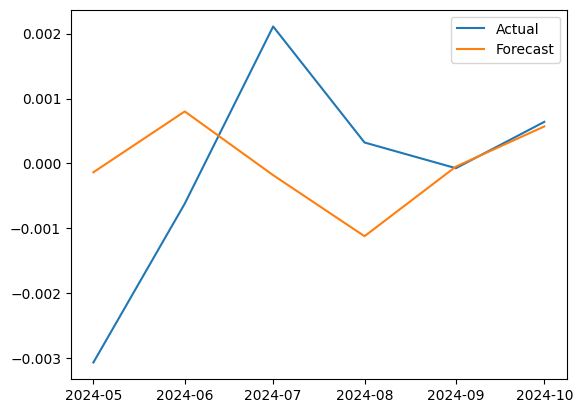

In [54]:
# Compare CPIAUCSL with test
plt.plot(test_data['CPIAUCSL'], label='Actual')
plt.plot(forecast_df['CPIAUCSL'], label='Forecast')
plt.legend()
plt.show()

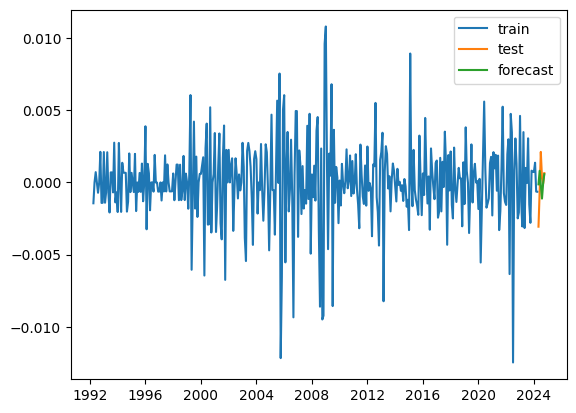

In [55]:
# Plot the full series
plt.plot(train_data['CPIAUCSL'], label='train')
plt.plot(test_data['CPIAUCSL'], label='test')
plt.plot(forecast_df['CPIAUCSL'], label='forecast')
plt.legend()
plt.show()

In [ ]:
# Calculate the RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test_data['CPIAUCSL'], forecast_df['CPIAUCSL']))
print(f'RMSE: {rmse}')

# 2  factors: RMSE: 0.0017294340254425543
# 5  factors: RMSE: 0.0014529727833682935 
# 10 factors: RMSE: 0.0032837672882791444
# 20 factors: RMSE: 0.014173743242750537


RMSE: 0.0017294340254425543


In [62]:
# Get relative RMSE
rmse = 0.0017294340254425543
print(f"Relative RMSE: {rmse / test_data['CPIAUCSL'].mean() * 100:.2f}%")
# Normalize RMSE
print(f"Normalized RMSE: {rmse / (test_data['CPIAUCSL'].max() - test_data['CPIAUCSL'].min())}")

Relative RMSE: -1511.16%
Normalized RMSE: 0.3340685670229421
